In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ================== Step 1: Data Preparation ==================

# Directories for labeled training, validation, and test datasets
train_dir = os.path.join('D:/DL&AI Project/Spectorgram_op', 'train')
val_dir = os.path.join('D:/DL&AI Project/Spectorgram_op', 'val')

# Define transformations for training and validation datasets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ConvNeXt input
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ConvNeXt input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets for training and validation
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ================== Step 2: Load Pre-trained ConvNeXt and Modify ==================

# Load pre-trained ConvNeXt model
convnext_model = models.convnext_base(weights=models.ConvNeXt_Base_Weights.DEFAULT)

# Modify the final fully connected layer to match the number of classes in your dataset
num_classes = len(train_dataset.classes)
convnext_model.classifier[2] = nn.Linear(convnext_model.classifier[2].in_features, num_classes)

# Move model to GPU if available
convnext_model = convnext_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_model.parameters(), lr=0.0001)

# ================== Step 3: Load Last Epoch ==================

# Check if there's a saved epoch file and load the last epoch
last_epoch_file = 'D:/last_epoch.txt'
start_epoch = 0  # Default starting epoch
best_val_acc = 0.0  # Initialize the best validation accuracy

if os.path.exists(last_epoch_file):
    with open(last_epoch_file, 'r') as f:
        start_epoch = int(f.read().strip())
    # Load the best saved model
    convnext_model.load_state_dict(torch.load('D:/best_convnext_model.pth'))

# ================== Step 4: Model Training ==================

num_epochs = 20

for epoch in range(start_epoch, num_epochs):
    # Training phase
    convnext_model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = convnext_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}')

    # Validation phase
    convnext_model.eval()
    val_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = convnext_model(inputs)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_acc = val_running_corrects.double() / len(val_dataset)
    print(f'Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {val_acc:.4f}')

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(convnext_model.state_dict(), 'D:/best_convnext_model.pth')

    # Save the current epoch
    with open(last_epoch_file, 'w') as f:
        f.write(str(epoch + 1))  # Save the next epoch to start from

print(f'Best Validation Accuracy: {best_val_acc:.4f}')

# ================== Step 5: Classify Unlabelled Data ==================

# Directory for unlabelled dataset
unlabelled_dir = os.path.join('D:/DL&AI Project/Respiratory_Sound_Database/Respiratory_Sound_Database/Spectrogram_audio_op', 'audio_copd')

# Load unlabelled dataset with the same transforms as validation/test sets
unlabelled_dataset = datasets.ImageFolder(unlabelled_dir, transform=val_test_transforms)
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=32, shuffle=False)

# Load the best saved model
convnext_model.load_state_dict(torch.load('D:/best_convnext_model.pth'))
convnext_model = convnext_model.to(device)
convnext_model.eval()

# Make predictions on the unlabelled data
predictions = []

with torch.no_grad():
    for inputs in unlabelled_loader:  # Only unpack inputs since there are no labels
        inputs = inputs[0].to(device)  # Get the tensor from the DataLoader
        outputs = convnext_model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

# Map predicted indices back to class names
class_names = train_dataset.classes
predicted_classes = [class_names[p] for p in predictions]

# Output predicted classes for unlabelled data
print("Predicted classes for unlabelled data:")
for i, class_name in enumerate(predicted_classes):
    print(f'File {i + 1}: {class_name}')


Epoch 1/20 - Train Loss: 1.4910, Train Accuracy: 0.4019
Epoch 1/20 - Validation Accuracy: 0.4048
Epoch 2/20 - Train Loss: 1.3601, Train Accuracy: 0.4395
Epoch 2/20 - Validation Accuracy: 0.5476
Epoch 3/20 - Train Loss: 1.1564, Train Accuracy: 0.5367
Epoch 3/20 - Validation Accuracy: 0.5516
Epoch 4/20 - Train Loss: 0.8984, Train Accuracy: 0.6458
Epoch 4/20 - Validation Accuracy: 0.6310
Epoch 5/20 - Train Loss: 0.6285, Train Accuracy: 0.7743
Epoch 5/20 - Validation Accuracy: 0.6944
Epoch 6/20 - Train Loss: 0.4598, Train Accuracy: 0.8357
Epoch 6/20 - Validation Accuracy: 0.7341
Epoch 7/20 - Train Loss: 0.2827, Train Accuracy: 0.9011
Epoch 7/20 - Validation Accuracy: 0.6865
Epoch 8/20 - Train Loss: 0.1694, Train Accuracy: 0.9454
Epoch 8/20 - Validation Accuracy: 0.7698
Epoch 9/20 - Train Loss: 0.1571, Train Accuracy: 0.9483
Epoch 9/20 - Validation Accuracy: 0.7698
Epoch 10/20 - Train Loss: 0.0986, Train Accuracy: 0.9704
Epoch 10/20 - Validation Accuracy: 0.6587
Epoch 11/20 - Train Loss: 0.

FileNotFoundError: Couldn't find any class folder in D:/DL&AI Project/Respiratory_Sound_Database/Respiratory_Sound_Database/Spectrogram_audio_op\audio_copd.

In [13]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for the unlabelled dataset
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ConvNeXt input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom dataset for unlabelled images
class UnlabelledDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Directory for unlabelled dataset (audio_copd)
unlabelled_dir = os.path.join('D:/DL&AI Project/Respiratory_Sound_Database/Respiratory_Sound_Database/Spectrogram_audio_op', 'audio_copd')

# Load unlabelled dataset with the same transforms as validation/test sets
unlabelled_dataset = UnlabelledDataset(unlabelled_dir, transform=val_test_transforms)
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=32, shuffle=False)

# Load the best saved model
convnext_model = models.convnext_base(weights=models.ConvNeXt_Base_Weights.DEFAULT)  # Load pre-trained model
num_classes = len(train_dataset.classes)  # Get number of classes from your training dataset
convnext_model.classifier[2] = nn.Linear(convnext_model.classifier[2].in_features, num_classes)  # Modify the last layer
# Load the best saved model with weights_only set to True
convnext_model.load_state_dict(torch.load('D:/best_convnext_model.pth', weights_only=True))
convnext_model = convnext_model.to(device)
convnext_model.eval()

# Make predictions on the unlabelled data
predictions = []

with torch.no_grad():
    for inputs in unlabelled_loader:
        inputs = inputs.to(device)  # Move inputs to the device (GPU or CPU)
        outputs = convnext_model(inputs)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get predicted class indices
        predictions.extend(preds.cpu().numpy())  # Store predictions

# Map predicted indices back to class names
class_names = train_dataset.classes
predicted_classes = [class_names[p] for p in predictions]

# Output predicted classes for unlabelled data
print("Predicted classes for unlabelled data:")
for i, class_name in enumerate(predicted_classes):
    print(f'File {i + 1}: {class_name}')


Predicted classes for unlabelled data:
File 1: COPD1
File 2: COPD2
File 3: COPD4
File 4: COPD2
File 5: COPD4
File 6: COPD3
File 7: COPD3
File 8: COPD4
File 9: COPD4
File 10: COPD4
File 11: COPD4
File 12: COPD3
File 13: COPD4
File 14: COPD3
File 15: COPD4
File 16: COPD2
File 17: COPD2
File 18: COPD4
File 19: COPD4
File 20: COPD4
File 21: COPD4
File 22: COPD4
File 23: COPD4
File 24: COPD4
File 25: COPD4
File 26: COPD2
File 27: COPD4
File 28: COPD4
File 29: COPD4
File 30: COPD4
File 31: COPD3
File 32: COPD3
File 33: COPD3
File 34: COPD4
File 35: COPD4
File 36: COPD3
File 37: COPD3
File 38: COPD4
File 39: COPD2
File 40: COPD4
File 41: COPD3
File 42: COPD3
File 43: COPD2
File 44: COPD2
File 45: COPD3
File 46: COPD3
File 47: COPD3
File 48: COPD3
File 49: COPD2
File 50: COPD2
File 51: COPD3
File 52: COPD1
File 53: COPD2
File 54: COPD2
File 55: COPD3
File 56: COPD4
File 57: COPD4
File 58: COPD4
File 59: COPD4
File 60: COPD4
File 61: COPD4
File 62: COPD3
File 63: COPD3
File 64: COPD4
File 65: C

Predicted classes for unlabelled data:
File 1: COPD1
File 2: COPD2
File 3: COPD4
File 4: COPD2
File 5: COPD4
File 6: COPD3
File 7: COPD3
File 8: COPD4
File 9: COPD4
File 10: COPD4
File 11: COPD4
File 12: COPD3
File 13: COPD4
File 14: COPD3
File 15: COPD4
File 16: COPD2
File 17: COPD2
File 18: COPD4
File 19: COPD4
File 20: COPD4
File 21: COPD4
File 22: COPD4
File 23: COPD4
File 24: COPD4
File 25: COPD4
File 26: COPD2
File 27: COPD4
File 28: COPD4
File 29: COPD4
File 30: COPD4
File 31: COPD3
File 32: COPD3
File 33: COPD3
File 34: COPD4
File 35: COPD4
File 36: COPD3
File 37: COPD3
File 38: COPD4
File 39: COPD2
File 40: COPD4
File 41: COPD3
File 42: COPD3
File 43: COPD2
File 44: COPD2
File 45: COPD3
File 46: COPD3
File 47: COPD3
File 48: COPD3
File 49: COPD2
File 50: COPD2
File 51: COPD3
File 52: COPD1
File 53: COPD2
File 54: COPD2
File 55: COPD3
File 56: COPD4
File 57: COPD4
File 58: COPD4
File 59: COPD4
File 60: COPD4
File 61: COPD4
File 62: COPD3
File 63: COPD3
File 64: COPD4
File 65: C

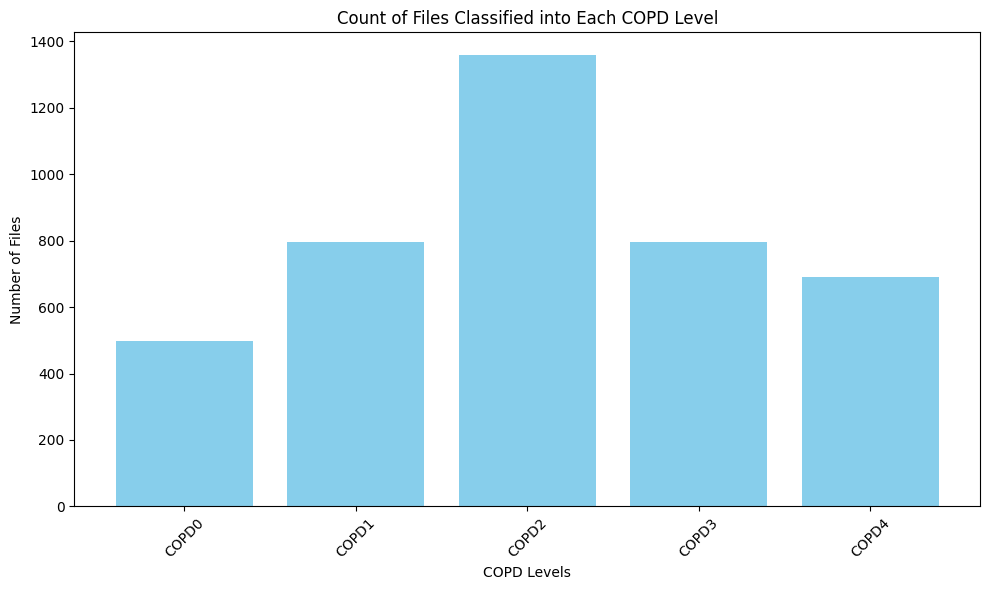

In [14]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for the unlabelled dataset
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ConvNeXt input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom dataset for unlabelled images
class UnlabelledDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Directory for unlabelled dataset (audio_copd)
unlabelled_dir = os.path.join('D:/DL&AI Project/Respiratory_Sound_Database/Respiratory_Sound_Database/Spectrogram_audio_op', 'audio_copd')

# Load unlabelled dataset with the same transforms as validation/test sets
unlabelled_dataset = UnlabelledDataset(unlabelled_dir, transform=val_test_transforms)
unlabelled_loader = DataLoader(unlabelled_dataset, batch_size=32, shuffle=False)

# Load the best saved model
convnext_model = models.convnext_base(weights=models.ConvNeXt_Base_Weights.DEFAULT)  # Load pre-trained model
num_classes = len(train_dataset.classes)  # Get number of classes from your training dataset
convnext_model.classifier[2] = nn.Linear(convnext_model.classifier[2].in_features, num_classes)  # Modify the last layer
# Load the best saved model with weights_only set to True
convnext_model.load_state_dict(torch.load('D:/best_convnext_model.pth', weights_only=True))
convnext_model = convnext_model.to(device)
convnext_model.eval()

# Make predictions on the unlabelled data
predictions = []
class_count = {class_name: 0 for class_name in train_dataset.classes}  # Initialize a count dictionary

with torch.no_grad():
    for inputs in unlabelled_loader:
        inputs = inputs.to(device)  # Move inputs to the device (GPU or CPU)
        outputs = convnext_model(inputs)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get predicted class indices
        predictions.extend(preds.cpu().numpy())  # Store predictions

        # Update the class count
        for p in preds.cpu().numpy():
            class_name = train_dataset.classes[p]
            class_count[class_name] += 1

# Map predicted indices back to class names
predicted_classes = [train_dataset.classes[p] for p in predictions]

# Output predicted classes for unlabelled data
print("Predicted classes for unlabelled data:")
for i, class_name in enumerate(predicted_classes):
    print(f'File {i + 1}: {class_name}')

# Output count of files classified in each COPD level
print("\nCount of files classified in each COPD level:")
for class_name, count in class_count.items():
    print(f'{class_name}: {count}')

# Create a bar graph for the counts
plt.figure(figsize=(10, 6))
plt.bar(class_count.keys(), class_count.values(), color='skyblue')
plt.xlabel('COPD Levels')
plt.ylabel('Number of Files')
plt.title('Count of Files Classified into Each COPD Level')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit labels
plt.show()  # Display the bar graph
